Setup

In [1]:
import sys
sys.path.append('Libraries/')
import pclpy
import cv2
from imp import reload
import glob
import os
import numpy as np
import pcl
import pdal
import segTree
import pandas as pd
import Visualization
import Utils

from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

#Utils
def tic():
    global timestart
    timestart = time.perf_counter()
    
def toc():
    global timestart
    return time.perf_counter()-timestart

Load Cloud and visualize

In [2]:
PointCloud = pclpy.pcl.PointCloud.PointXYZ()
pclpy.pcl.io.loadPCDFile('D:/Documentos/ParaAutonomia/Python/Proyecto/Data/NistClouds/downsampledlesscloudEURO1.pcd',PointCloud)
Visualization.PCL3dpaint(PointCloud)

Use PDAL to apply a Morphological Filter to seperate ground and non ground points

In [3]:
AllGround = []
AllNonGround = []  
Nogroundpoints,ground = segTree.FloorRemove(PointCloud)

NongroundCloud = pclpy.pcl.PointCloud.PointXYZ(Nogroundpoints)
GroundCloud = pclpy.pcl.PointCloud.PointXYZ(ground)

Visualization.PCL3dpaint([NongroundCloud,GroundCloud])

Set Algorithm Parameters

In [4]:
verticalityThresh = 0.06
NonNANcurvatureThresh = 0.1

lowstems_Height = 5
cutstems_Height = 5

In [5]:
reload(Visualization)
reload(segTree)
reload(Utils)

<module 'Utils' from 'Libraries\\Utils.py'>

In [28]:
Visualization.PCL3dpaint(cluster_list)

Run main process

In [17]:
#Get point normals for filtering

Ksearch = 0.08
normals = segTree.ExtractNormals(NongroundCloud.xyz, Ksearch)
Visualization.PCL3dpaint([NongroundCloud.xyz,NongroundCloud.xyz+normals.normals*0.1,NongroundCloud.xyz+normals.normals*0.2])

nanmask = np.bitwise_not(np.isnan(normals.normals[:,0]))
NonNANpoints = NongroundCloud.xyz[nanmask]
NonNANnormals = normals.normals[nanmask]
NonNANcurvature = normals.curvature[nanmask]
verticality = np.dot(NonNANnormals,[[0],[0],[1]])
mask = (verticality < verticalityThresh) & (-verticalityThresh < verticality)  #0.1
maskC = (NonNANcurvature < NonNANcurvatureThresh)## 0.12
Fmask = mask.ravel() & maskC.ravel()

onlyhorizontalpoints = NonNANpoints[Fmask]
onlyhorizontalnormals = NonNANnormals[Fmask]

Visualization.PCL3dpaint([onlyhorizontalpoints,onlyhorizontalpoints+onlyhorizontalnormals*0.05,onlyhorizontalpoints+onlyhorizontalnormals*0.1])

cluster_list = segTree.EucladeanClusterExtract(onlyhorizontalpoints, tol=0.1, minc=40, maxc=6000000)
Visualization.PCL3dpaint(cluster_list)

#Group stem segments
GroupStems = []

bufferStems = cluster_list.copy()
for n,p in enumerate(cluster_list):
    Centroid = np.mean(p, axis = 0)
    _, S,vT = np.linalg.svd(p-Centroid)
    strieghtness = S[0]/(S[0]+S[1]+S[2])
    
    clustersDICT = {}
    clustersDICT['cloud'] = p
    clustersDICT['strieghtness'] = strieghtness
    clustersDICT['center'] = Centroid
    clustersDICT['direction'] = vT
    GroupStems.append(clustersDICT)

bufferStems = [i['cloud'] for i in GroupStems]
for treenumber1 in reversed(range(0,len(bufferStems))):
    for treenumber2 in reversed(range(0,treenumber1-1)):
        center1 = GroupStems[treenumber1]['center']
        center2 = GroupStems[treenumber2]['center']
        angle1 = GroupStems[treenumber1]['direction'][0]
        angle2 = GroupStems[treenumber2]['direction'][0]
        dist1 = Utils.DistPoint2Line(center2,angle1+center1,center1)
        dist2 = Utils.DistPoint2Line(center1,angle2+center2,center2)
        if (dist1<0.4) | (dist2<0.4):
            bufferStems[treenumber2] = np.vstack([bufferStems[treenumber2],bufferStems.pop(treenumber1)])
            break

            
Visualization.PCL3dpaint(bufferStems)

pointpart = GroundCloud.xyz
#groundseg = groundCloud.xyz[center]
A = np.c_[np.ones(pointpart.shape[0]), pointpart[:,:2], np.prod(pointpart[:,:2], axis=1), pointpart[:,:2]**2]
C,_,_,_ = np.linalg.lstsq(A, pointpart[:,2])
#Corners.PCL3dpaint(cluster_list)

StemsWithGround = []
for i in bufferStems:
    center = np.mean(i,0)
    X,Y = center[:2]
    Z = np.dot(np.c_[np.ones(X.shape), X, Y, X*Y, X**2, Y**2], C)
    StemsWithGround.append([i,[X,Y,Z[0]]])

#lowStems = [i for i in StemsWithGround if np.min(i[0],axis=0)[2] < (3 + i[1][2])]
#cutstems = [i[i[:,2]<(3+np.min(i[:,2]))] for i in lowStems]

lowStems = [i for i in StemsWithGround if np.min(i[0],axis=0)[2] < (lowstems_Height + i[1][2])]
cutstems = [[i[0][i[0][:,2]<(cutstems_Height + i[1][2])],i[1]] for i in lowStems]

Visualization.PCL3dpaint([i[0] for i in cutstems])

finalstems = []
stemcyls = []
rech = []
for p in cutstems:
    segpoints = p[0]
    indices, model = segTree.segment_normals(segpoints, searchRadius=0.1, model=pcl.SACMODEL_CYLINDER, method=pcl.SAC_RANSAC, normalweight=0.01, miter=10000, distance=0.08, rlim=[0,0.4])
    if len(indices)>0:
        if abs(np.dot(model[3:6],[0,0,1])/np.linalg.norm(model[3:6])) > 0.5:
            newmodel = model
            Z = 1.3 + p[1][2]
            Y = model[1] + model[4] * (Z - model[2]) / model[5]
            X = model[0] + model[3] * (Z - model[2]) / model[5]
            newmodel[0:3] = np.array([X,Y,Z])
            newmodel[3:6] = Utils.similarize(newmodel[3:6],[0,0,1])
            finalstems.append({'tree':segpoints[indices],'model':newmodel})
            stemcyls.append(Utils.makecylinder(model=newmodel,length=7,dense=60))
        else:
            rech.append(segpoints)
    else:
        rech.append(segpoints)

Visualization.PCL3dpaint([i['tree'] for i in finalstems] + stemcyls)
        

C:\Users\omara\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [18]:
#####################################################
#Get ground truth
treedata = pd.read_csv('D:/Documentos/ParaAutonomia/Python/Proyecto/Data/EuroSDR_DataRelease/EuroSDR_DataRelease/TLS_Benchmarking_Plot_1_LHD.txt',sep = '\t',names = ['x','y','height','DBH'])
Xcor,Ycor,diam = treedata.iloc[0,[0,1,3]]
surtreesL1 = [Utils.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=20)]
Zcor = 0
TreeDict = [np.array([Xcor,Ycor,diam])]
for i,rows in treedata.iloc[1:].iterrows():
    Xcor,Ycor,diam = rows.iloc[[0,1,3]]
    if not np.any(np.isnan([Xcor,Ycor,diam])):
        surtreesL1.append(Utils.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=10))
        TreeDict.append(np.array([Xcor,Ycor,diam]))
surtrees1 = [p for i in surtreesL1 for p in i]
surtreesCloud1 = pclpy.pcl.PointCloud.PointXYZ(surtrees1)

            #DataBase
#Found trees
#Hungarian Algorithm assignment
CostMat = np.ones([len(TreeDict),len(stemcyls)])
for X,datatree in enumerate(TreeDict):
    for Y,foundtree in enumerate(finalstems):
        CostMat[X,Y] = np.linalg.norm([datatree[0:2]-foundtree['model'][0:2]])

dataindex, foundindex = linear_sum_assignment(CostMat,maximize=False)

#Get metrics
locationerror = []
correctlocationerror = []
diametererror = []
cloudmatch = []
for i,j in zip(dataindex, foundindex):
    locationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
    if locationerror[-1]<0.4:
        diametererror.append(abs(finalstems[j]['model'][6]*2-TreeDict[i][2]))        
        correctlocationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
    cloudmatch.append(np.vstack([surtreesL1[i],finalstems[j]['tree'],stemcyls[j]]))

In [19]:
#PCA filtering and Eucladian Clustering
Visualization.PCL3dpaint(cloudmatch)

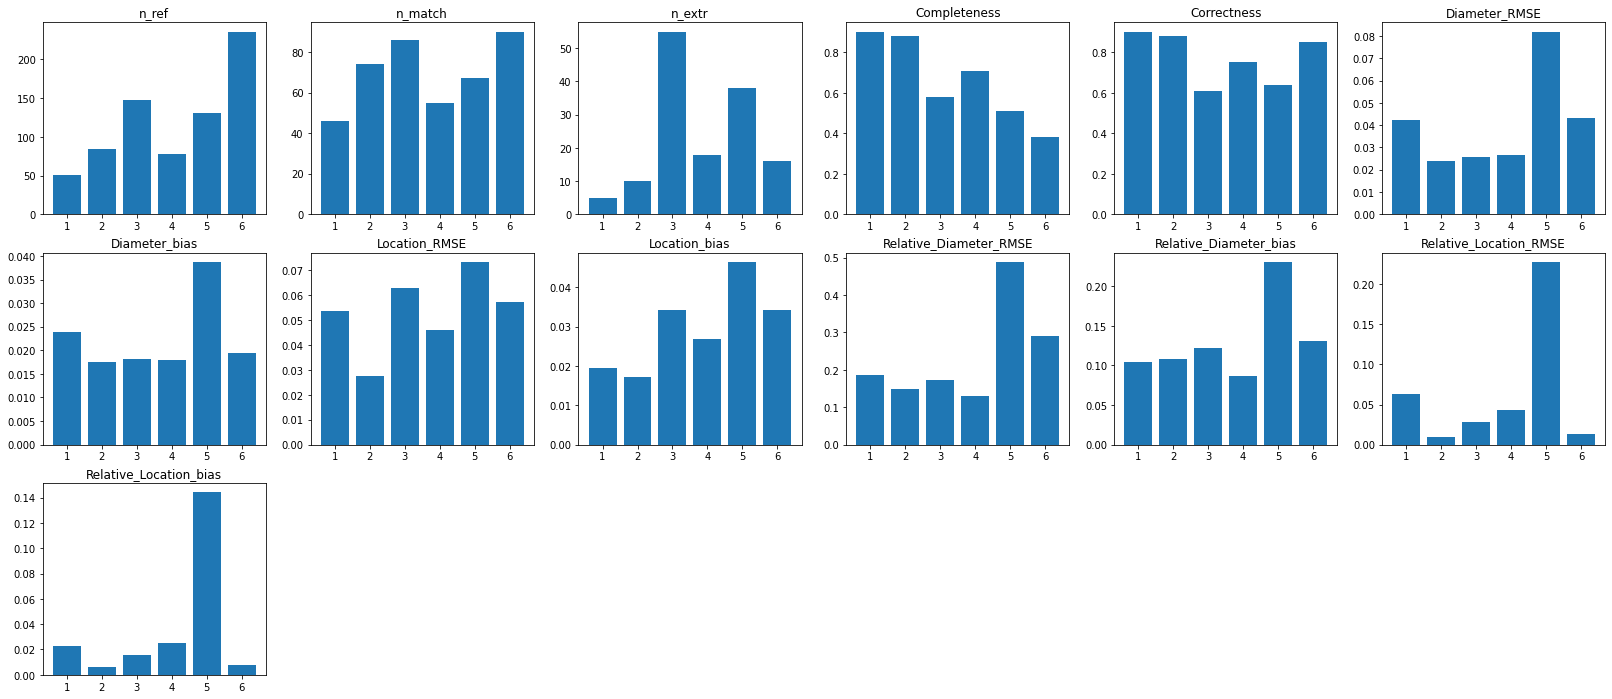

In [37]:
alldata = ['n_ref', 'n_match', 'n_extr', 'Completeness', 'Correctness', 'Diameter_RMSE', 'Diameter_bias', 
           'Location_RMSE', 'Location_bias', 'Relative_Diameter_RMSE', 'Relative_Diameter_bias', 'Relative_Location_RMSE', 'Relative_Location_bias']
plt.figure(figsize=(28,12))
for n,i in enumerate(alldata):
    plt.subplot(3,6,n+1)
    plt.title(i)
    plt.bar(np.array([1,2,3,4,5,6]),eval(i))